In [1]:
import sys
sys.path.append('..')

In [29]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from DomainPrediction import BaseProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools

In [4]:
root = '../..'
data_path = os.path.join(root, 'Data/')

In [6]:
## Read Protein
protein = BaseProtein(file=os.path.join(data_path, 'GxpS_ATC_AF.pdb'))
A = [i for i in range(33,522)] ## 34-522
C = [i for i in range(637,1067)] ## 638-1067
T = [i for i in range(538, 608)] ## 539-608

In [7]:
protein.get_residues(T) ## Get domains - Here T

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [ ]:
## Create fasta file with WT T domain
file = os.path.join(data_path, 'GxpS.T.fasta')
helper.create_fasta({'GxpS.T': protein.get_residues(T)}, file)

In [ ]:
## Create fasta file with WT 
file = os.path.join(data_path, 'GxpS.fasta')
helper.create_fasta({'GxpS': protein.sequence}, file)

In [ ]:
## Demo of reading fasta
file = os.path.join(data_path, 'GxpS.T.fasta')
sequences = helper.read_fasta(file, mode='str')

In [ ]:
sequences

In [ ]:
'''
    We had seq for ATC from esm3
    Extracting T from the sequences and creating new fasta file
'''
gen_fasta = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000 copy.fasta')
sequences = helper.read_fasta(gen_fasta)
seq_dict = {}
for rec in sequences:
    seq_dict[rec.id] = ''.join([str(rec.seq)[i] for i in T])

file = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
helper.create_fasta(seq_dict, file)

In [ ]:
## Compute Seq ID after aligning to WT
wt = os.path.join(data_path, 'GxpS.T.fasta')
gen = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
seq_ids = metrics.compute_sequence_identity(wt, gen, hmm=pfam_T_hmm)

In [ ]:
_ = plt.hist(seq_ids)

In [ ]:
## % of sequences that contain the motif FF__GG_S
gen = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
metrics.search_and_filter_motif(gen)

In [ ]:
hmmer = HmmerTools()

gen = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
df = hmmer.hmmsearch(hmm_path=pfam_T_hmm, fasta_file=gen)

_ = plt.hist(-np.log(df['Evalue']))
_ = plt.xlabel('-log(E value)')

In [8]:
save_path = os.path.join(data_path, 'esm_experiments/gen_1000/pdbs_GxpS_ATC')
file = os.path.join(save_path, 'GxpS_ATC-temp_0.5-gen_980.pdb')

In [9]:
class FoldedProtein(BaseProtein):
    def __init__(self, file : str, id: str = 'default') -> None:
        super().__init__(file, id)
        
        self.plddts = np.array([a.get_bfactor() for a in self.struct.get_atoms()])
        self.plddt = self.plddts.mean()
        self.pTM = None
        self.pAE = None

        if os.path.isfile(file.replace('.pdb', '.meta.npz')):
            metadata = np.load(file.replace('.pdb', '.meta.npz'))
            self.pTM = metadata['ptm']
            self.pAE = metadata['predicted_aligned_error']

In [10]:
fp = FoldedProtein(file)

In [11]:
folded_proteins = []
for f in os.listdir(save_path):
    file = os.path.join(save_path, f)
    if f.endswith('.pdb'):
        folded_proteins.append(FoldedProtein(file))

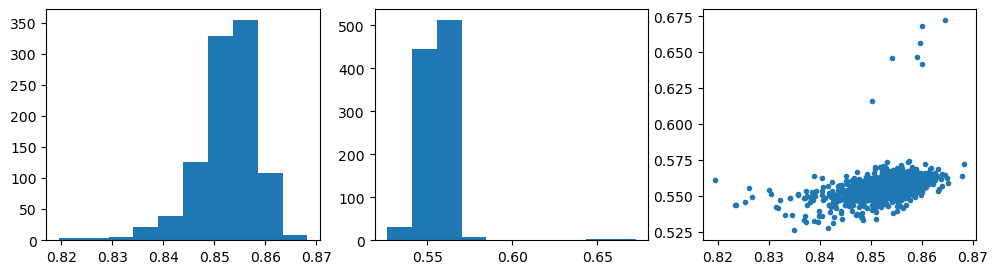

In [12]:
## pLDDT and pTM scores
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
_ = ax[0].hist([f.plddt for f in folded_proteins])
_ = ax[1].hist([f.pTM for f in folded_proteins])
_ = plt.scatter([f.plddt for f in folded_proteins], [f.pTM for f in folded_proteins], marker='.')

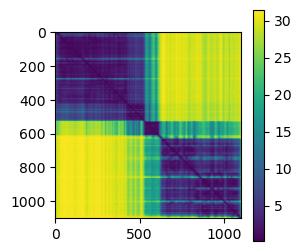

In [16]:
plt.figure(figsize=(3,3))
_ = plt.imshow(folded_proteins[5].pAE)
_ = plt.colorbar()

In [17]:
import subprocess
import re

class TMalign():
    def __init__(self, path) -> None:
        self.tmalign = path

    def run(self, prot_a, prot_b):
        out = subprocess.check_output([self.tmalign, prot_a, prot_b])
        data = str(out).split("\\n")
        for d in data:
            x = re.sub(r"\s\s+", " ", d).split(' ')
            if x[0] == 'Aligned':
                rmsd = float(x[4][:-1])
                seq_id = float(x[6])
            elif x[0] == 'TM-score=':
                tm_score = float(x[1])
                break

        return {
            'rmsd': rmsd,
            'seq_id': seq_id,
            'tm_score': tm_score
        }

In [26]:
tm_path = '/nethome/kgeorge/workspace/DomainPrediction/src/DomainPrediction/utils/TMalign'
tmalign = TMalign(tm_path)

In [42]:
## tm scores to list, has rmsd and seq id
## Better to update npz file
save_path = os.path.join(data_path, 'esm_experiments/gen_1000/pdbs_GxpS_ATC')
ref_structure = os.path.join(data_path, 'GxpS_ATC_EF.pdb')

TM_scores = []
for f in tqdm(os.listdir(save_path)):
    file = os.path.join(save_path, f)
    if f.endswith('.pdb'):
        TM_scores.append(tmalign.run(ref_structure, file)['tm_score'])

100%|██████████| 2000/2000 [1:41:04<00:00,  3.03s/it]  


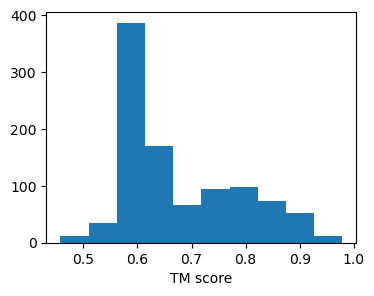

In [43]:
plt.figure(figsize=(4,3))
_ = plt.hist(TM_scores)
_ = plt.xlabel('TM score')

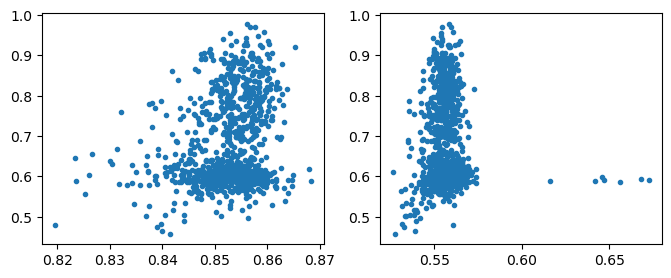

In [44]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
_ = ax[0].scatter([f.plddt for f in folded_proteins], TM_scores, marker='.')
_ = ax[1].scatter([f.pTM for f in folded_proteins], TM_scores, marker='.')

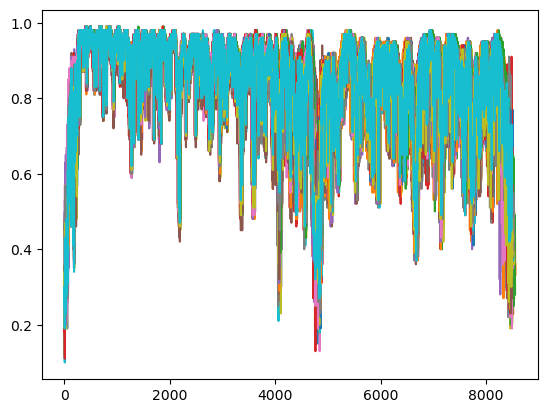

In [41]:
for i in range(100):
    plt.plot(folded_proteins[i].plddts)